In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts


###  Reading in relevant data

Reading in BH position data from Corral-Santan et al 2016. (https://www.aanda.org/articles/aa/abs/2016/03/aa27130-15/aa27130-15.html)

In [2]:
df=pd.read_csv('Corral_data_simplified.csv')


Reading in SNR position/radius data from Green et al 2014 (http://www.mrao.cam.ac.uk/surveys/snrs/snrs.data.html)
Note that elliptical SNRs have an average radius reported.

In [3]:
df_SNRs=pd.read_csv('Green_Catalog_SNRs.csv')


Here's what it looks like:

In [5]:
df.sample(5)


,year,object,RA,Dec,l,b,distance,distance error,Refs
48,1977,H 1705-250,17 08 15.52,-25 05 30.15,358.5874,9.0569,8.6,2.1,"Kaluzienski1977,Yang2012,Griffiths1978,Jonker2004"
47,1985,SLX 1746-331,17 49 48.94,-33 12 11.60,356.8092,-2.9736,NaN,NaN,"Skinner1990,Torres2007b"
8,2011,MAXI J1543-564,15 43 17.18,-56 24 49.61,325.0855,-1.1214,NaN,NaN,"Negoro2011a,Miller-Jones2011b"
39,1992,GRS 1915+105,19 15 11.55,+10 56 44.80,45.3656,-0.2194,9,2,"Castro-Tirado1992,Dhawan2000,Reid2014,Zdziarsk..."
24,2002,XTE J1908+094,19 08 53.08,+09 23 04.84,43.2615,0.4377,6.5,3.5,"Woods2002,Miller-Jones2013b,Chaty2006b"


In [7]:
df_SNRs.head(5)


,Lon,Lat,av Rad
0,0.0,0.0,3.0
1,0.3,0.0,11.5
2,0.9,0.1,8.0
3,1.0,-0.1,8.0
4,1.4,-0.1,10.0


Putting the longitudes into a (-180,180) coordinate system for ease of fitting

In [8]:
df['l_180'] = df.apply(
    lambda row: ((row.l +180) % 360) -180,
    axis=1
)


In [9]:
df_SNRs['Lon_180'] = df_SNRs.apply(
    lambda row: ((row.Lon + 180) % 360) -180,
    axis=1
)


Here's the Milky Way Galxy, as we know it:

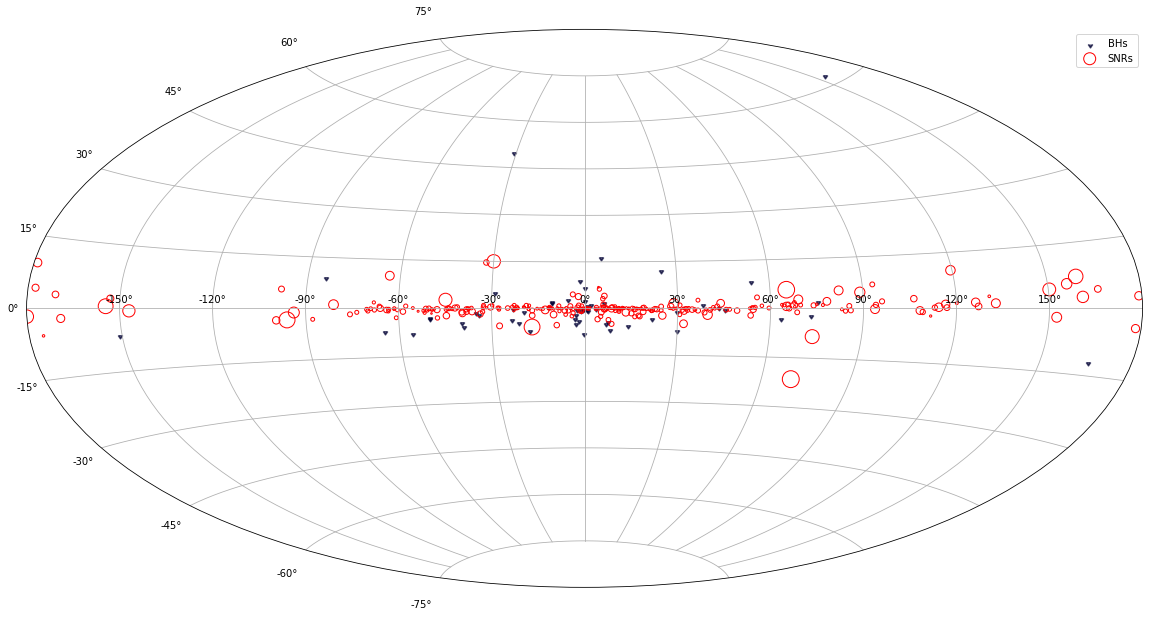

In [10]:
#For skyplott
#import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord

gal_BH = SkyCoord(df['l_180'], df['b'], frame='galactic', unit=u.deg)
gal_SNR = SkyCoord(df_SNRs['Lon_180'], df_SNRs['Lat'], frame='galactic', unit=u.deg)

plt.figure(figsize=(20,20))
plt.subplot(111, projection='aitoff')
plt.grid(True)

plt.scatter(gal_BH.l.wrap_at('180d').radian,gal_BH.b.radian,marker=11,s=20,color='#000033',alpha=0.7,label='BHs')
plt.scatter(gal_SNR.l.wrap_at('180d').radian,gal_SNR.b.radian,s=df_SNRs['av Rad'], facecolors='none', edgecolors='r',label='SNRs')
plt.legend()

plt.show()


### Now some tools for fitting and resampling the data:

In [35]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


def kde(x,
        x_grid,
        bandwidth=5.0,
        **kwargs
       ):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def generate_rand_from_pdf(pdf,
                           x_grid,
                           number
                          ):
    """ """
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1] 
    values = np.random.rand(number)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf


def take_data_return_resample(data,
                              bins,
                              xmin,
                              xmax,
                              label='label',
                              bandwidth=5.0,
                              number_of_samples=1000,
                              show_plots=True):

    x_grid = np.linspace(xmin, xmax, 10000)
    delta_x= x_grid[2]-x_grid[1]
    
    kdepdf = kde(data,
                 x_grid,
                 bandwidth=bandwidth
                ) # creating a kde from the data
    random_from_kde = generate_rand_from_pdf(kdepdf,
                                             x_grid,
                                             number_of_samples
                                            ) + (np.random.rand(number_of_samples)-0.5)*2*delta_x
                                            # sampling the generated kde and adding random number within each band
    
    if show_plots == True :
        fig= plt.figure(figsize=(12,4))
        plt.subplot(121)
        plt.hist(data, bins, density=True, alpha=0.5, label=label+' (real)')
        plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label=label+' (kde)')
        plt.title("Fitting to the Galactic distribution")
        plt.xlim(xmin,xmax)
        plt.legend()

        plt.subplot(122)
        plt.hist(random_from_kde, bins, alpha=0.5, label=label+' (artificial)',color='purple')
        plt.legend()
        plt.xlim(xmin,xmax)
        plt.title("Sampling from a Galactic-like distribution")
        plt.show()

    return random_from_kde


def battleships(NoSNRs,
                NoBHlmxb,
                BH_lon,
                SNR_lon,
                BH_lat,
                SNR_lat,
                SNR_rad
               ):
    """Checking for Overlap between BHs and SNRs"""
    AllHits = [] 
    for s in range (0,NoSNRs):
        for b in range (0,NoBHlmxb):
            displacement=np.sqrt((BH_lon[b]-SNR_lon[s])**2+(BH_lat[b]-SNR_lat[s])**2)
            
            if displacement <= (1.0/3.0)*SNR_rad[s]:
                Hit=1
                #print('   ---Hit...',BH_lon[b],SNR_lon[s],BH_lat[b],SNR_lat[s],SNR_rad[s])
            else:
                Hit=0               
            AllHits.append(Hit) #adding up hits
    return sum(AllHits)



## Showing how we resample the BH and SNR distributions:

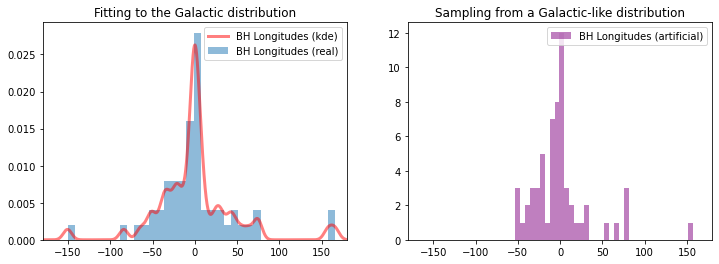

In [13]:
BH_longs = take_data_return_resample(df['l_180'], 36, -180, 180, label='BH Longitudes',bandwidth=5,number_of_samples=60)

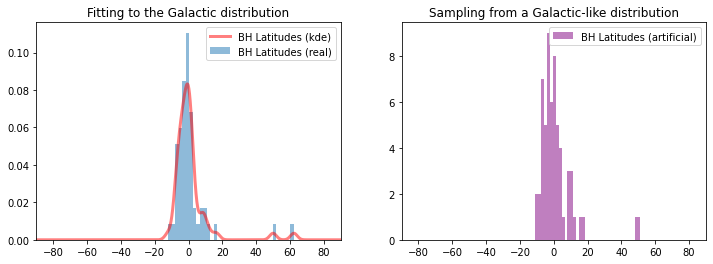

In [14]:
BH_lats = take_data_return_resample(df['b'], 36, -90, 90, label='BH Latitudes',bandwidth=2,number_of_samples=60)


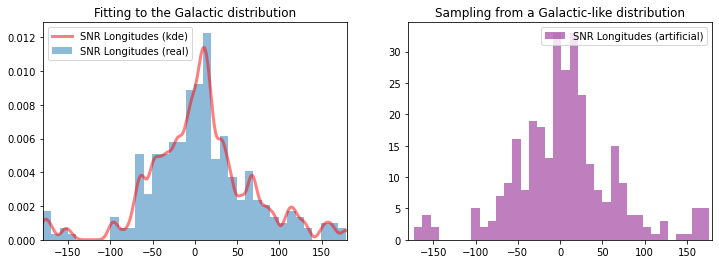

In [15]:
SNR_longs = take_data_return_resample(df_SNRs['Lon_180'], 36, -180, 180, label='SNR Longitudes',bandwidth=5,number_of_samples=300)


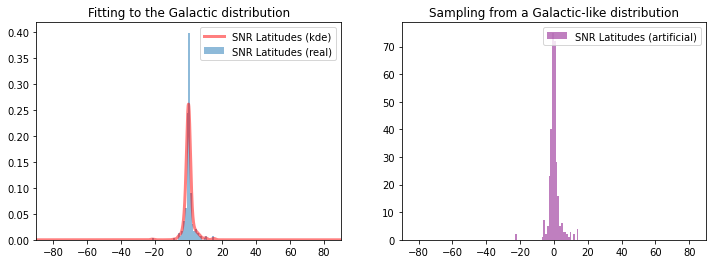

In [16]:
SNR_lats = take_data_return_resample(df_SNRs['Lat'], 36, -90, 90, label='SNR Latitudes',bandwidth=1,number_of_samples=300)


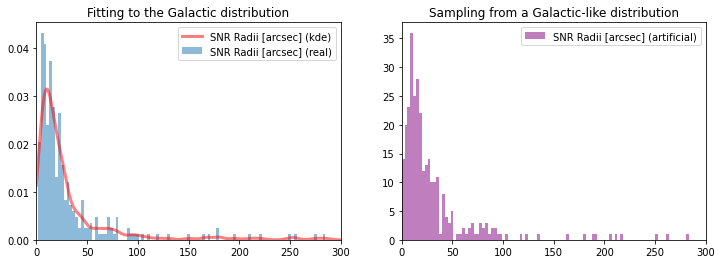

In [17]:
SNR_Rad = take_data_return_resample(df_SNRs['av Rad'], 100, 0, 300, label='SNR Radii [arcsec]',bandwidth=5,number_of_samples=300)


# Now to generate an ensemble of simulated Milky Way-like galaxies

In [41]:
GalNo=100000 # How many Galaxies to build

No_BHs=60
No_SNRs=300


In [42]:
#Counters
TotalHits_OneGal=0
TotalHits_AllGal=0

#looping over Galaxies
for j in range(0,GalNo):

    #Generate BHs and SNRs
    BH_lon = take_data_return_resample(df['l_180'], 
                                      36, 
                                      -180, 
                                      180, 
                                      'BH Longitudes',
                                      bandwidth=5,
                                      number_of_samples=60,
                                      show_plots=False
                                      )
    BH_lat = take_data_return_resample(df['b'],
                                       36,
                                       -90,
                                       90,
                                       label='BH Latitudes',
                                       bandwidth=3,
                                       number_of_samples=60,
                                       show_plots=False
                                      )

    SNR_lon = take_data_return_resample(df_SNRs['Lon_180'],
                                        36,
                                        -180,
                                        180,
                                        label='SNR Longitudes',
                                        bandwidth=5,
                                        number_of_samples=300,
                                        show_plots=False
                                       )
    SNR_lat = take_data_return_resample(df_SNRs['Lat'],
                                        36,
                                        -90,
                                        90,
                                        label='SNR Latitudes',
                                        bandwidth=1,
                                        number_of_samples=300,
                                        show_plots=False
                                        )
    SNR_rad = take_data_return_resample(df_SNRs['av Rad'],
                                        100,
                                        0,
                                        300,
                                        label='SNR Radii [arcsec]',
                                        bandwidth=5,
                                        number_of_samples=300,
                                        show_plots=False
                                       )


    #Examine Overlap.  NoSNRs, NoBHlmxb, BH_lon, SNR_lon, BH_lat, SNR_lat, SNR_rad
    TotalHits_OneGal = battleships(No_SNRs, No_BHs, BH_lon, SNR_lon, BH_lat, SNR_lat, (1.0/60.0)*SNR_rad)


    TotalHits_AllGal = TotalHits_AllGal + TotalHits_OneGal


    if ((j+1)%1000) == 0 : print('Galaxy no. ',j+1,', total hits so far = ',TotalHits_AllGal)



TotalBHs=GalNo*No_BHs
Prob_given_BH=(TotalHits_AllGal/TotalBHs)*100.0
Prob_in_Galaxy=(TotalHits_AllGal/GalNo)*100.0



print('Out of ',GalNo,' Galaxies and ',TotalBHs,' BHs, there were ',TotalHits_AllGal,' instances of near-centre overlap')
print('Chance probability of coincidence of a given BH is ',Prob_given_BH,'%')
print('Chance probability of coincidence within the Milky Way is ',Prob_in_Galaxy,'%')

Galaxy no.  1000 , total hits so far =  2286
Galaxy no.  2000 , total hits so far =  4523
Galaxy no.  3000 , total hits so far =  6785
Galaxy no.  4000 , total hits so far =  9092
Galaxy no.  5000 , total hits so far =  11444
Galaxy no.  6000 , total hits so far =  13762
Galaxy no.  7000 , total hits so far =  16030
Galaxy no.  8000 , total hits so far =  18260
Galaxy no.  9000 , total hits so far =  20577
Galaxy no.  10000 , total hits so far =  22892
Galaxy no.  11000 , total hits so far =  25209
Galaxy no.  12000 , total hits so far =  27532
Galaxy no.  13000 , total hits so far =  29773
Galaxy no.  14000 , total hits so far =  32033
Galaxy no.  15000 , total hits so far =  34203
Galaxy no.  16000 , total hits so far =  36533
Galaxy no.  17000 , total hits so far =  38852
Galaxy no.  18000 , total hits so far =  41185
Galaxy no.  19000 , total hits so far =  43425
Galaxy no.  20000 , total hits so far =  45768
Galaxy no.  21000 , total hits so far =  48045
Galaxy no.  22000 , total 

Now we have a BH-SNR chance overlap likelihood estimate 

# Now to visualise the final simulated Galaxy, as a sanity check

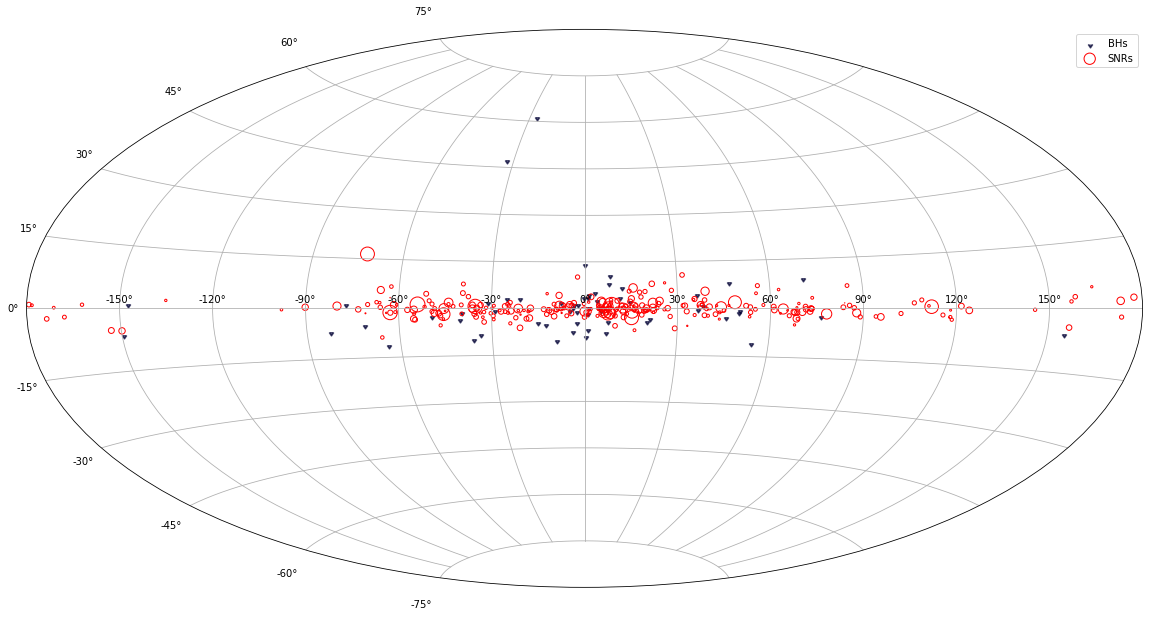

In [39]:
gal_BH = SkyCoord(BH_lon[:], BH_lat[:], frame='galactic', unit=u.deg)
gal_SNR = SkyCoord(SNR_lon[:], SNR_lat[:], frame='galactic', unit=u.deg)

plt.figure(figsize=(20,20))
plt.subplot(111, projection='aitoff')
plt.grid(True)

plt.scatter(gal_BH.l.wrap_at('180d').radian,gal_BH.b.radian,marker=11,s=20,color='#000033',alpha=0.7,label='BHs')
plt.scatter(gal_SNR.l.wrap_at('180d').radian,gal_SNR.b.radian,s=SNR_rad, facecolors='none', edgecolors='r',label='SNRs')
plt.legend()

plt.show()
